In [1]:
import juliet
import corner
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [3]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [4]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]

In [16]:
priors = {
    "P_p1": dict(distribution="normal", hyperparameters=[ground_truth["period"], 0.1]),
    "t0_p1": dict(distribution="normal", hyperparameters=[1.3, 0.1]),
    "p_p1": dict(distribution="uniform", hyperparameters=[0.01, 0.1]), # r
    "b_p1": dict(distribution="fixed", hyperparameters=0),
    "a_p1": dict(distribution="normal", hyperparameters=[ground_truth["a"], ground_truth["a"]/10]),
    "ecc_p1": dict(distribution="fixed", hyperparameters=0),
    "omega_p1": dict(distribution="fixed", hyperparameters=90),
    "mdilution_fake": dict(distribution="fixed", hyperparameters=1),
    "mflux_fake": dict(distribution="fixed", hyperparameters=0),
    "q1_fake": dict(distribution="uniform", hyperparameters=[0, 1]),
    "q2_fake": dict(distribution="uniform", hyperparameters=[0, 1]),
    "sigma_w_fake": dict(distribution="fixed", hyperparameters=0) # yerr
}

In [6]:
init = {
    "P_p1": ground_truth["period"],
    "t0_p1": ground_truth["t0"],
    "p_p1": ground_truth["r"],
    "b_p1": 0,
    "a_p1": ground_truth["a"],
    "ecc_p1": 0,
    "omega_p1": 90,
    "mdilution_fake": 1,
    "mflux_fake": 0,
    "q1_fake": ground_truth["us"][0],
    "q2_fake":ground_truth["us"][1],
    "sigma_w_fake": 1e-4
}

In [17]:
outpath = datadir("juliet/generated_data_100ppm")
os.makedirs(outpath, exist_ok=True)
dataset = juliet.load(priors=priors, t_lc=dict(fake=t), y_lc=dict(fake=flux), yerr_lc=dict(fake=np.full_like(flux, ground_truth["yerr"])), out_folder=outpath, starting_point=init)

In [19]:
results = dataset.fit(dynesty_sample="slice", n_live_points=1000)

PyMultinest installation not detected. Forcing dynesty as the sampler.


28090it [20:48, 22.50it/s, +1000 | bound: 165 | nc: 1 | ncall: 650111 | eff(%):  4.475 | loglstar:   -inf < 112239.011 <    inf | logz: 112210.795 +/-  0.253 | dlogz:  0.001 >  1.009]


In [20]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('fake', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# Get phases:
phases = juliet.get_phases(dataset.times_lc['fake'], P, t0)

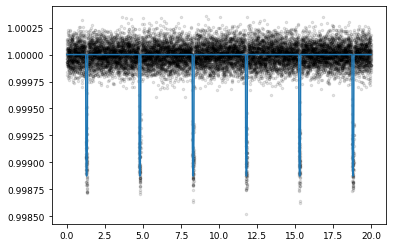

In [21]:
plt.scatter(t, flux, color="k", marker=".", alpha=0.1)
plt.plot(t, transit_model)

(-0.1, 0.1)

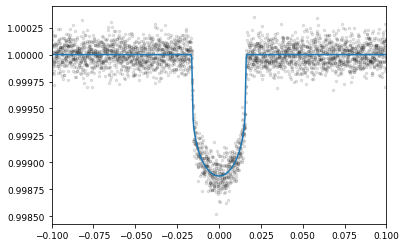

In [23]:
plt.scatter(phases, flux, color="k", marker=".", alpha=0.1)
idx = np.argsort(phases)
plt.plot(phases[idx], transit_model[idx])
plt.xlim((-0.1, 0.1))

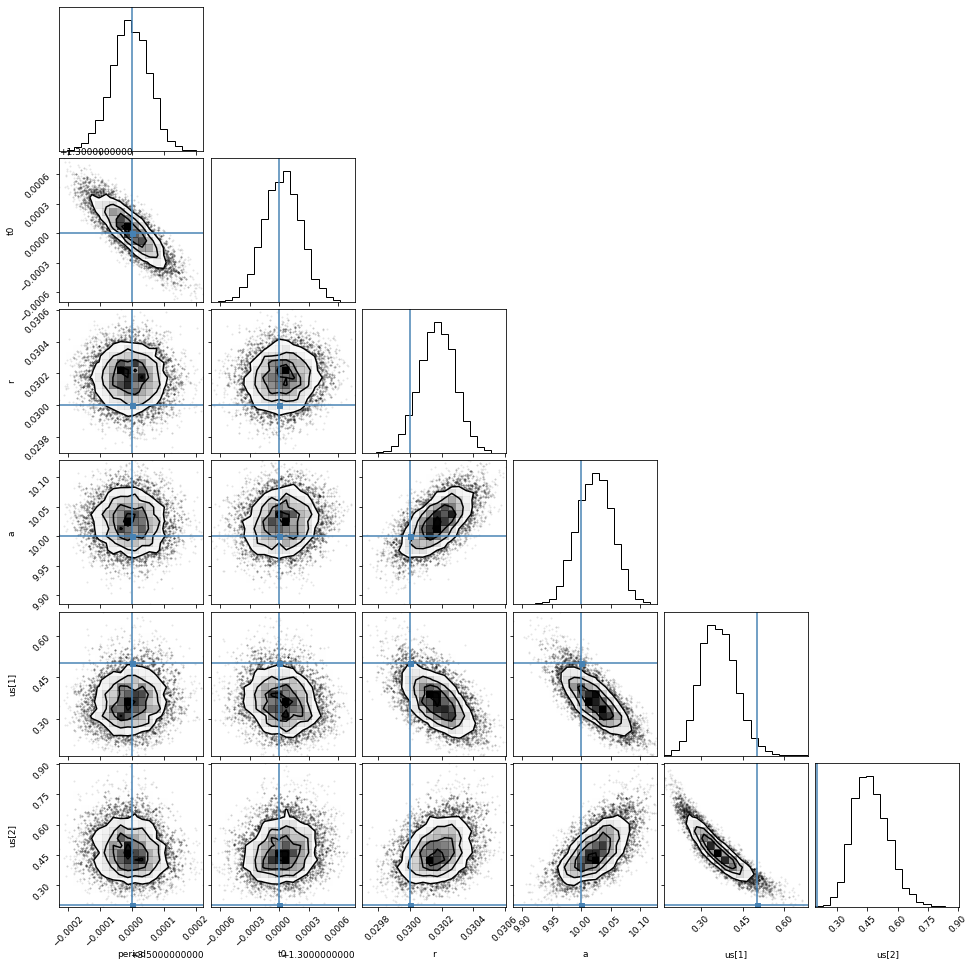

In [36]:
param_names = ["P_p1", "t0_p1", "p_p1", "a_p1", "q1_fake", "q2_fake"]
first_time = True
for param in param_names:
    if first_time:
        posterior_data = results.posteriors['posterior_samples'][param]
        first_time = False
    else:
        posterior_data = np.vstack((posterior_data, results.posteriors['posterior_samples'][param]))
posterior_data = posterior_data.T


var_names = ["period", "t0", "r", "a", "us[1]", "us[2]"]

truths = []
for v in var_names:
    if v.startswith("us"):
        idx = int(v[-2]) - 1
        truths.append(ground_truth["us"][idx])
    else:
        truths.append(ground_truth[v])

_ = corner.corner(
    posterior_data,
    labels=var_names,
    truths=truths,
)

In [ ]:
results.